In [1]:
import numpy as np

def patch_asscalar(a):
    return a.item()

setattr(np, "asscalar", patch_asscalar)

def patch_alen(a):
    return 1 if np.isscalar(a) else len(a)

setattr(np, "alen", patch_alen)

In [2]:
import sys, os
from astropy.io import fits
import matplotlib.pyplot as plt
import sunpy
import sunpy.map
from datetime import datetime as dt
import time
import _pickle as cPickle
import astropy.units as u
import imreg_dft

from sunpy.coordinates import get_body_heliographic_stonyhurst, frames
from astropy.wcs import WCS
import reproject
from reproject import reproject_adaptive,reproject_exact,reproject_interp
from scipy.ndimage import map_coordinates

import sunpy.visualization.colormaps
font = {'family' : 'Open Sans',
        'weight' : 'normal',
        'size'   : 15}

import sunpy.visualization.colormaps as cm
import matplotlib as mpl
magmap = mpl.colormaps['hmimag']

import matplotlib.patches as patches
mpl.rc_file_defaults()
plt.rc('font', **font)
mpl.rcParams['image.origin'] = 'lower'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

/scratch/slam/sinjan/.conda/envs/p310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(reproject.__version__)

0.1.dev1280+g51379b1.d20250115


In [19]:
def get_hrt_remapped_R(hrt_file, hmi_file, err):
    
    from datetime import datetime as dt
    print(dt.now())

    errx=err[0]
    erry=err[1]
    h = fits.getheader(hrt_file)
    h['CRVAL1']=h['CRVAL1']-errx
    h['CRVAL2']=h['CRVAL2']-erry
    tmp = fits.getdata(hrt_file)
    arr=np.zeros(tmp.shape)
    arr[150:-150,150:-150]=tmp[150:-150,150:-150]
    hrt_map = sunpy.map.Map(arr,h)

    #magnetogram = sunpy.map.Map(hmi_file).rotate()
    #hpc_coords = sunpy.map.all_coordinates_from_map(magnetogram)
    #mask = ~sunpy.map.coordinate_is_on_solar_disk(hpc_coords)
    #hmi_map = sunpy.map.Map(magnetogram.data, magnetogram.meta, mask=mask)
    hmi_map=sunpy.map.Map(hmi_file).rotate()

    out_header = sunpy.map.make_fitswcs_header(
         hmi_map.data.shape, hmi_map.reference_coordinate.replicate(rsun=hrt_map.reference_coordinate.rsun),
         scale=u.Quantity(hmi_map.scale),
         instrument="SO/PHI-HRT",
         observatory="SolO",
         wavelength=hrt_map.wavelength
         )
    out_header['dsun_obs'] = hmi_map.coordinate_frame.observer.radius.to(u.m).value
    out_header['hglt_obs'] = hmi_map.coordinate_frame.observer.lat.value
    out_header['hgln_obs'] = hmi_map.coordinate_frame.observer.lon.value
    
    out_header['crpix1'] = hmi_map.fits_header['CRPIX1']
    out_header['crpix2'] = hmi_map.fits_header['CRPIX2']
    out_header['crval1'] = hmi_map.fits_header['CRVAL1']
    out_header['crval2'] = hmi_map.fits_header['CRVAL2']    
    out_header['PC1_1'] = hmi_map.fits_header['PC1_1']
    out_header['PC1_2'] = hmi_map.fits_header['PC1_2']
    out_header['PC2_1'] = hmi_map.fits_header['PC2_1']
    out_header['PC2_2'] = hmi_map.fits_header['PC2_2']
    out_header['cdelt1'] = hmi_map.fits_header['cdelt1']
    out_header['cdelt2'] = hmi_map.fits_header['cdelt2']
    out_WCS=WCS(out_header)

    hrt_repro, footprint = reproject_adaptive(hrt_map, out_WCS, hmi_map.data.shape,kernel='hann',sample_region_width=1,kernel_width=10000)
    hrt_repro=sunpy.map.Map((hrt_repro, out_WCS))
    #arr_mask=np.zeros(tmp.shape)
    #arr_mask[150:-150,150:-150]=1
    #mask_map = sunpy.map.Map(arr_mask,h)
    #mask_hrt,_= reproject_adaptive(mask_map, out_WCS, hmi_map.data.shape,kernel='Gaussian',sample_region_width=1)
    #mask_hrt[mask_hrt<1]=np.nan
    #hrt_remap = sunpy.map.Map((hrt_repro*mask_hrt, hmi_map.meta))
    #print(dt.now())
    
    return hrt_repro, hmi_map

In [8]:
filedir = '/data/solo/phi/data/fmdb/public/l2/2023-10-12/'
bfile = 'solo_L2_phi-hrt-blos_20231012T001503_V202408291137_0350120601.fits.gz'
hrt_file = filedir+bfile

hmifiledir = '/scratch/slam/sinjan/arlongterm_hmi/'
hmibfile = 'blos_45/hmi.m_45s.20231012_002145_TAI.2.magnetogram.fits'
hmi_file = hmifiledir+hmibfile

In [13]:
x_hmi=300
y_hmi=2310

In [66]:
hrt_121023_b = fits.getdata(filedir+bfile)
hrt_121023_bm = sunpy.map.Map(filedir+bfile)
hmi_121023_b = sunpy.map.Map(hmifiledir+hmibfile).rotate()

In [9]:
def get_hmi_hrt_aligned(hrt_file,hmi_file):
    err=(-1.934214925750382, 113.7871115449891)
    hrt_remap, hmi_map = get_hrt_remapped_R(hrt_file, hmi_file, err)
    return [hrt_remap,hmi_map]

# kernel='Gaussian',kernel_width=10000,sample_region_width=1

In [10]:
hrt,hmi=get_hmi_hrt_aligned(hrt_file,hmi_file)

2025-01-15 14:38:42.131697
4102/4102 done12424147.0



In [12]:
#read the log_arlongterm_guassian.txt file

#extract the t,b,l,r values for pixel: 300,2310 (HMI), and compare to the pixel coord remap

"""
HMI target: x,y: (300, 2310) 
t,b,l,r: (1071.0, 1063.0, 1424.0, 1432.0)
t_r,b_r,l_r,r_r: (0.4960384940397944, -0.44900901890400746, -0.2184957193524042, 0.7265517935913977)
Pixels: 81.0
Pix count: 7418448.0
"""

'\nHMI target: x,y: (300, 2310)\nt,b,l,r: (1071.0, 1063.0, 1424.0, 1432.0)\nt_r,b_r,l_r,r_r: (0.4960384940397944, -0.44900901890400746, -0.2184957193524042, 0.7265517935913977)\nPixels: 81.0\nPix count: 7418448.0\n'

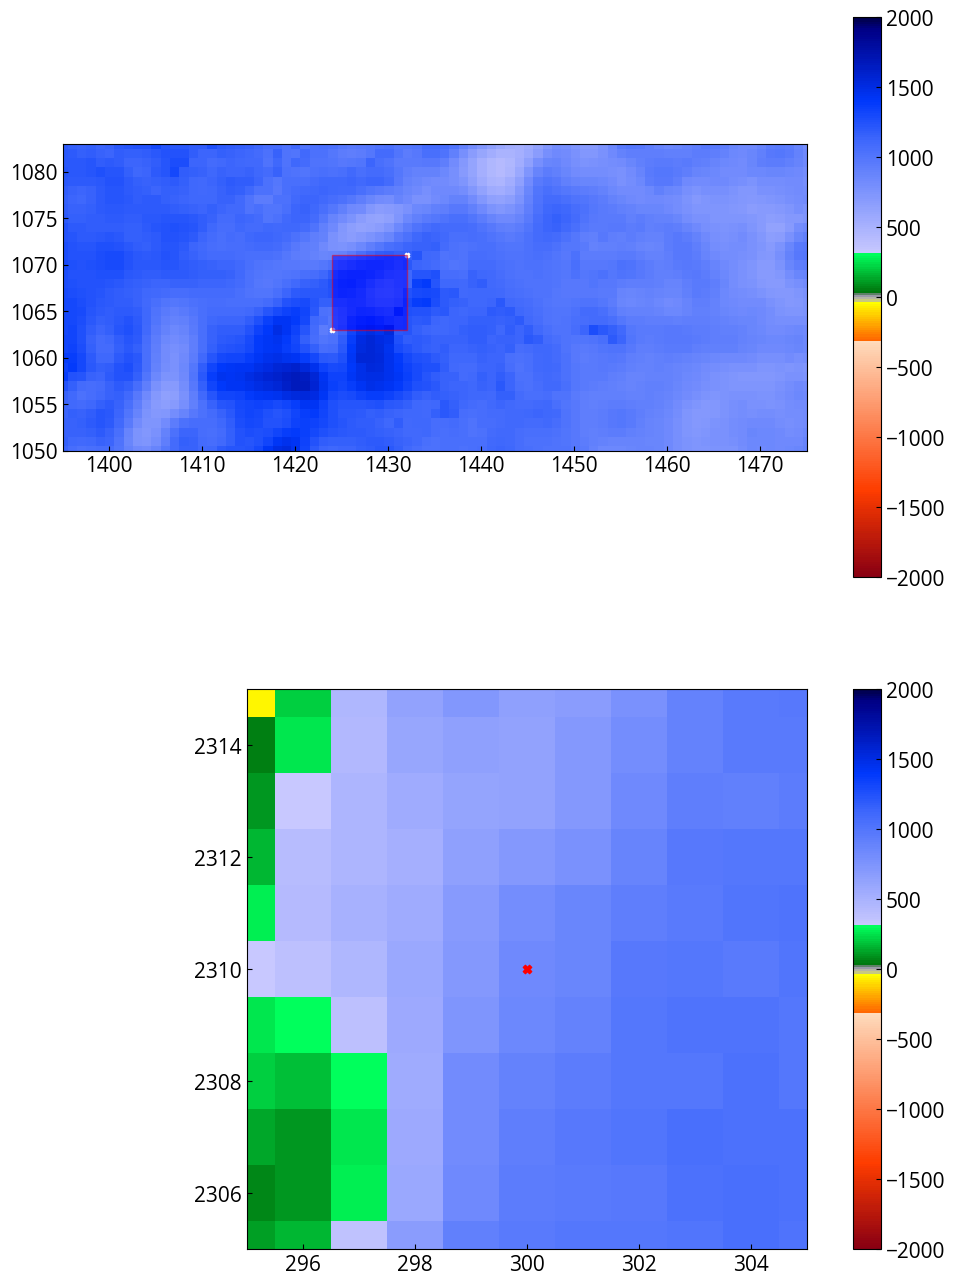

In [16]:
import matplotlib.patches as patches

plt.figure(figsize=(12,16))
plt.subplot(211)
im=plt.imshow(hrt_121023_b,origin="lower",cmap=magmap,vmin=-2000,vmax=2000)
blx=1424
bly=1063
trx=1432
tryy=1071
plt.scatter(blx,bly,marker='X',color='white',s=10)
plt.scatter(trx,tryy,marker='X',color='white',s=10)

ax=plt.gca()
rect = patches.Rectangle((blx, bly), trx-blx, tryy-bly, linewidth=1, edgecolor='r', facecolor='blue', alpha=0.5)
ax.add_patch(rect)

# blhmi=hmi_121023_b.pixel_to_world((x_hmi-5)*u.pixel,(y_hmi-5)*u.pixel)
# trhmi=hmi_121023_b.pixel_to_world((x_hmi+5)*u.pixel,(y_hmi+5)*u.pixel)

# blhrt=hrt_121023_b_map_shifttestn.world_to_pixel(blhmi)
# trhrt=hrt_121023_b_map_shifttestn.world_to_pixel(trhmi)
plt.colorbar(im)
plt.ylim(1050,1083)
plt.xlim(1395,1475)

plt.subplot(212)
hmi_121023_b.data[np.isnan(hmi_121023_b.data)]=0
im2=plt.imshow(hmi_121023_b.data,origin="lower",cmap=magmap,vmin=-2000,vmax=2000) #[2000:2550,:500]
plt.scatter(300,2310,marker='X',color='red')
plt.colorbar(im2)
plt.ylim(y_hmi-5,y_hmi+5)
plt.xlim(x_hmi-5,x_hmi+5)

plt.show()

In [17]:
"""
The kernel='Gaussian', results in these rectangular boxes:
elif kernel_flag == 1:
        # The Gaussian window is non-zero everywhere, but it's
        # close to zero almost everywhere. Sampling the whole input
        # image isn't tractable, so we truncate and sample only
        # within a certain region.
        # n.b. `s` currently contains the reciprocal of the
        # singular values
        top = sample_region_width / (2 * min(s[0], s[1]))
        #if yi>300 and xi>300:
        #    with gil:
        #        print('Config vals: ',sample_region_width, s[0], s[1],kernel_width)
        bottom = -top
        right = top
        left = -right
"""

"\nThe kernel='Gaussian', results in these rectangular boxes:\nelif kernel_flag == 1:\n        # The Gaussian window is non-zero everywhere, but it's\n        # close to zero almost everywhere. Sampling the whole input\n        # image isn't tractable, so we truncate and sample only\n        # within a certain region.\n        # n.b. `s` currently contains the reciprocal of the\n        # singular values\n        top = sample_region_width / (2 * min(s[0], s[1]))\n        #if yi>300 and xi>300:\n        #    with gil:\n        #        print('Config vals: ',sample_region_width, s[0], s[1],kernel_width)\n        bottom = -top\n        right = top\n        left = -right\n"

# kernel='Hann',kernel_width=10000,sample_region_width=1, kernel_width is ignored

# The Hann window is zero outside +/-1, so
                    # that's how far we need to go.
                    #
                    # The Hann window width is twice the width of a pixel---it
                    # runs to the centers of the neighboring pixels, rather
                    # than the edges of those pixels. This ensures that, at
                    # every point, the sum of the overlapping Hann windows is
                    # 1, and therefore that every input-image pixel is fully
                    # distributed into some combination of output pixels (in
                    # the limit of a Jacobian that is constant across all
                    # output pixels).

In [20]:
hrt,hmi=get_hmi_hrt_aligned(hrt_file,hmi_file)

2025-01-15 15:06:51.294139
4102/4102 done15729588.0



In [22]:
#read the log_arlongterm_guassian.txt file

#extract the t,b,l,r values for pixel: 300,2310 (HMI), and compare to the pixel coord remap

"""
HMI target: x,y: (300, 2310)
t,b,l,r: (1070.0, 1064.0, 1419.0, 1438.0)
t_r,b_r,l_r,r_r: (0.6018894498802183, -0.5548599747444314, -0.7056301867094135, 0.21368626094840693)
Pixels: 140.0
"""

'\nHMI target: x,y: (300, 2310)\nt,b,l,r: (1070.0, 1064.0, 1419.0, 1438.0)\nt_r,b_r,l_r,r_r: (0.6018894498802183, -0.5548599747444314, -0.7056301867094135, 0.21368626094840693)\nPixels: 140.0\n'

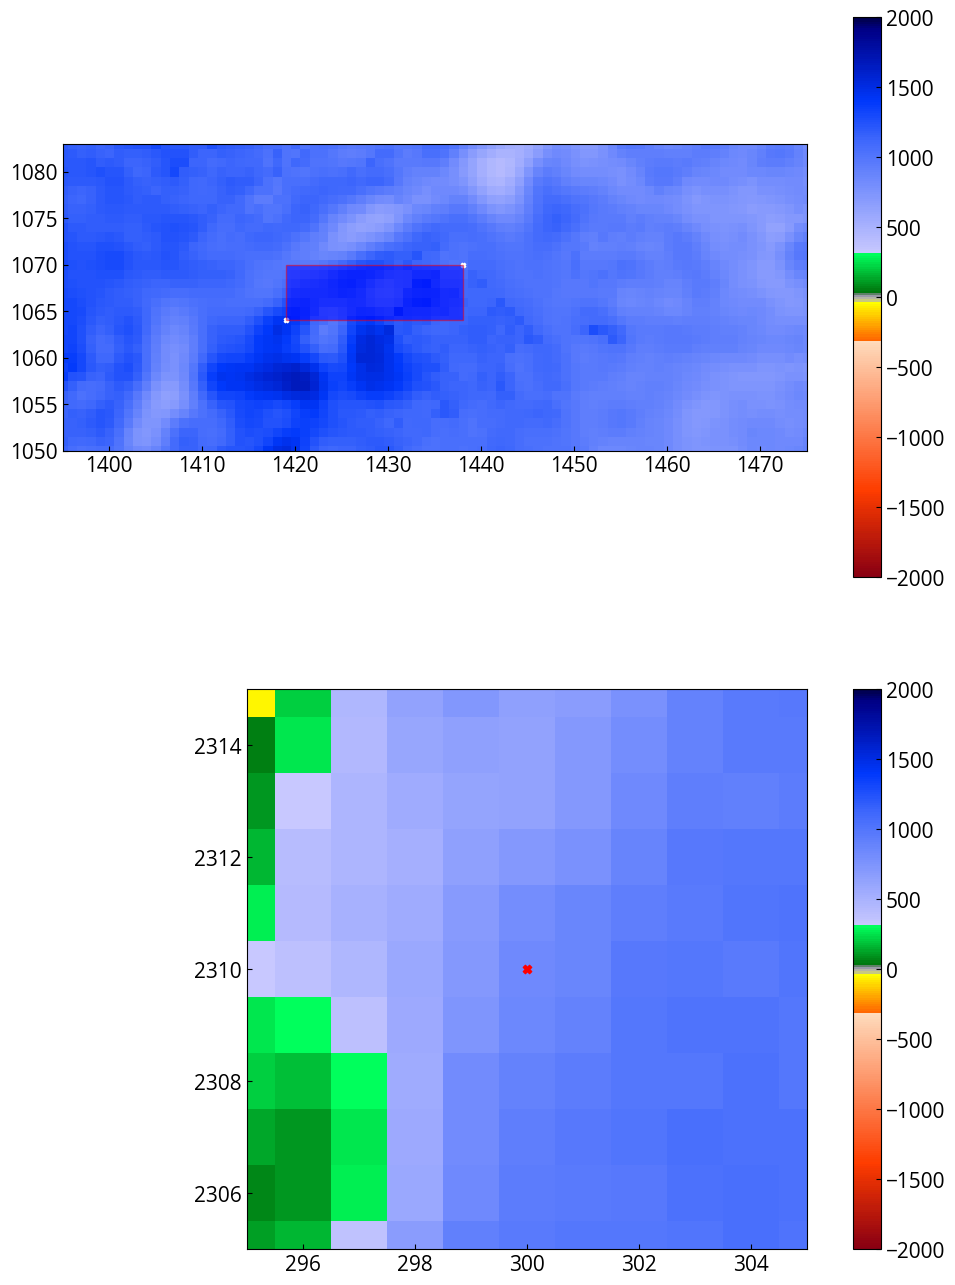

In [21]:
import matplotlib.patches as patches

plt.figure(figsize=(12,16))
plt.subplot(211)
im=plt.imshow(hrt_121023_b,origin="lower",cmap=magmap,vmin=-2000,vmax=2000)
blx=1419
bly=1064
trx=1438
tryy=1070
plt.scatter(blx,bly,marker='X',color='white',s=10)
plt.scatter(trx,tryy,marker='X',color='white',s=10)

ax=plt.gca()
rect = patches.Rectangle((blx, bly), trx-blx, tryy-bly, linewidth=1, edgecolor='r', facecolor='blue', alpha=0.5)
ax.add_patch(rect)

# blhmi=hmi_121023_b.pixel_to_world((x_hmi-5)*u.pixel,(y_hmi-5)*u.pixel)
# trhmi=hmi_121023_b.pixel_to_world((x_hmi+5)*u.pixel,(y_hmi+5)*u.pixel)

# blhrt=hrt_121023_b_map_shifttestn.world_to_pixel(blhmi)
# trhrt=hrt_121023_b_map_shifttestn.world_to_pixel(trhmi)
plt.colorbar(im)
plt.ylim(1050,1083)
plt.xlim(1395,1475)

plt.subplot(212)
hmi_121023_b.data[np.isnan(hmi_121023_b.data)]=0
im2=plt.imshow(hmi_121023_b.data,origin="lower",cmap=magmap,vmin=-2000,vmax=2000) #[2000:2550,:500]
plt.scatter(300,2310,marker='X',color='red')
plt.colorbar(im2)
plt.ylim(y_hmi-5,y_hmi+5)
plt.xlim(x_hmi-5,x_hmi+5)

plt.show()

In [23]:
#repeat above but for x number of pixels similar to `pixel_remap_explore.ipynb`

In [37]:
with open('./log_arlongterm_guassian_kernel.txt') as f:
    lines = f.readlines()

print(len(lines))
print(str(lines[0]))

print(lines[255675])

421790
HMI target: x,y: (175, 1974)

HMI target: x,y: (300, 2310)



In [83]:
import ast

def get_t_b_l_r_from_log(log_file,x_hmi,y_hmi):
    with open(log_file) as f:
        lines = f.readlines()

    lines = [s.strip() for s in lines] #get rid of newline character

    target = f'HMI target: x,y: {x_hmi, y_hmi}'
    line_index = lines.index(target)

    edges = ast.literal_eval(lines[line_index+1].split(': ')[1])
    return edges

In [54]:
edges=get_t_b_l_r_from_log('./log_arlongterm_guassian_kernel.txt',300,2310)

In [57]:
def get_phi_pixels_and_neighbours_from_log_edges(log_file,x_hmi,y_hmi,neighbour_length):
    phi_out_dicts = {}
    for x_offset in range(-neighbour_length,neighbour_length+1):
        neigh_x = int(x_hmi + x_offset)
        for y_offset in range(-neighbour_length,neighbour_length+1):
            neigh_y = int(y_hmi + y_offset)
            t,b,l,r = get_t_b_l_r_from_log(log_file,neigh_x,neigh_y)
            phi_out_dicts[f'HMI {(neigh_x,neigh_y)} bleft']=(l,b)
            phi_out_dicts[f'HMI {(neigh_x,neigh_y)} tright']=(r,t)

    return phi_out_dicts

In [60]:
phi_dict = get_phi_pixels_and_neighbours_from_log_edges('./log_arlongterm_guassian_kernel.txt',300,2310,1)
print(phi_dict)

{'HMI (299, 2309) bleft': (1417.0, 1060.0), 'HMI (299, 2309) tright': (1424.0, 1068.0), 'HMI (299, 2310) bleft': (1415.0, 1063.0), 'HMI (299, 2310) tright': (1423.0, 1071.0), 'HMI (299, 2311) bleft': (1414.0, 1067.0), 'HMI (299, 2311) tright': (1422.0, 1075.0), 'HMI (300, 2309) bleft': (1425.0, 1060.0), 'HMI (300, 2309) tright': (1433.0, 1068.0), 'HMI (300, 2310) bleft': (1424.0, 1063.0), 'HMI (300, 2310) tright': (1432.0, 1071.0), 'HMI (300, 2311) bleft': (1423.0, 1066.0), 'HMI (300, 2311) tright': (1431.0, 1074.0), 'HMI (301, 2309) bleft': (1434.0, 1059.0), 'HMI (301, 2309) tright': (1442.0, 1067.0), 'HMI (301, 2310) bleft': (1433.0, 1063.0), 'HMI (301, 2310) tright': (1441.0, 1071.0), 'HMI (301, 2311) bleft': (1432.0, 1066.0), 'HMI (301, 2311) tright': (1440.0, 1074.0)}


In [91]:
def plot_reproject_from_log(phi_out_dict,hmi_map,phi_map,title='Reproject',fontsize=16):
    hmi_pixels = list(set([(int(i.split('(')[1].split(')')[0].split(', ')[0]),\
                            int(i.split('(')[1].split(')')[0].split(', ')[1])) \
                           for i in phi_out_dict.keys()]))
    
    min_x_hmi_lim = min(set([i[0] for i in hmi_pixels]))-5
    max_x_hmi_lim = max(set([i[0] for i in hmi_pixels]))+5

    min_y_hmi_lim = min(set([i[1] for i in hmi_pixels]))-5
    max_y_hmi_lim = max(set([i[1] for i in hmi_pixels]))+5

    plt.figure(figsize=(12,20))
    plt.subplot(211)
    hmi_map.data[np.isnan(hmi_map.data)]=0
    
    hpc_coords = sunpy.map.all_coordinates_from_map(hmi_map)
    mask = ~sunpy.map.coordinate_is_on_solar_disk(hpc_coords)
        
    im=plt.imshow(hmi_map.data*~mask,origin="lower",cmap=magmap,vmin=-2000,vmax=2000) #[2000:2550,:500]
    plt.colorbar(im)
    plt.ylim(min_y_hmi_lim,max_y_hmi_lim)
    plt.xlim(min_x_hmi_lim,max_x_hmi_lim)
    for pix in hmi_pixels:
        plt.scatter(pix[0],pix[1],marker='X',s=10)
    drms_id = hmi_map.meta['drms_id']
    plt.title(f'{drms_id} - {hmi_map.date}')

    plt.subplot(212)
    im2=plt.imshow(phi_map.data,origin="lower",cmap=magmap,vmin=-2000,vmax=2000)

    ax=plt.gca()

    blks = []
    trks = []
    for pix in hmi_pixels:
        pix_dicts = {k: phi_out_dict[k] for k in phi_out_dict.keys() if str(pix) in k}
        blk = pix_dicts.get(f'HMI {pix} bleft')
        trk = pix_dicts.get(f'HMI {pix} tright')

        blks.append(blk)
        trks.append(trk)
        
        blx = blk[0]
        bly = blk[1] 
        trx = trk[0]
        tryy = trk[1] 
        rect = patches.Rectangle((blx, bly), trx-blx, tryy-bly, linewidth=1, facecolor='none', edgecolor='black')
        ax.add_patch(rect)

        centrex = blx + (trx-blx)/2 # obviously use a different formula for different shapes
        centrey = bly + (tryy-bly)/2
        plt.text(centrex, centrey,f'{pix}',horizontalalignment = 'center',verticalalignment = 'center',fontsize=fontsize)

    phi_x_min_lim = min(set([i[0] for i in blks]))-10
    phi_x_max_lim = max(set([i[0] for i in trks]))+10

    phi_y_min_lim = min(set([i[1] for i in blks]))-10
    phi_y_max_lim = max(set([i[1] for i in trks]))+10

    plt.xlim(phi_x_min_lim,phi_x_max_lim)
    plt.ylim(phi_y_min_lim,phi_y_max_lim)
    filename = phi_map.meta['filename']
    plt.title(f'{filename} - {phi_map.date}')
    plt.colorbar(im2,fraction=0.036)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

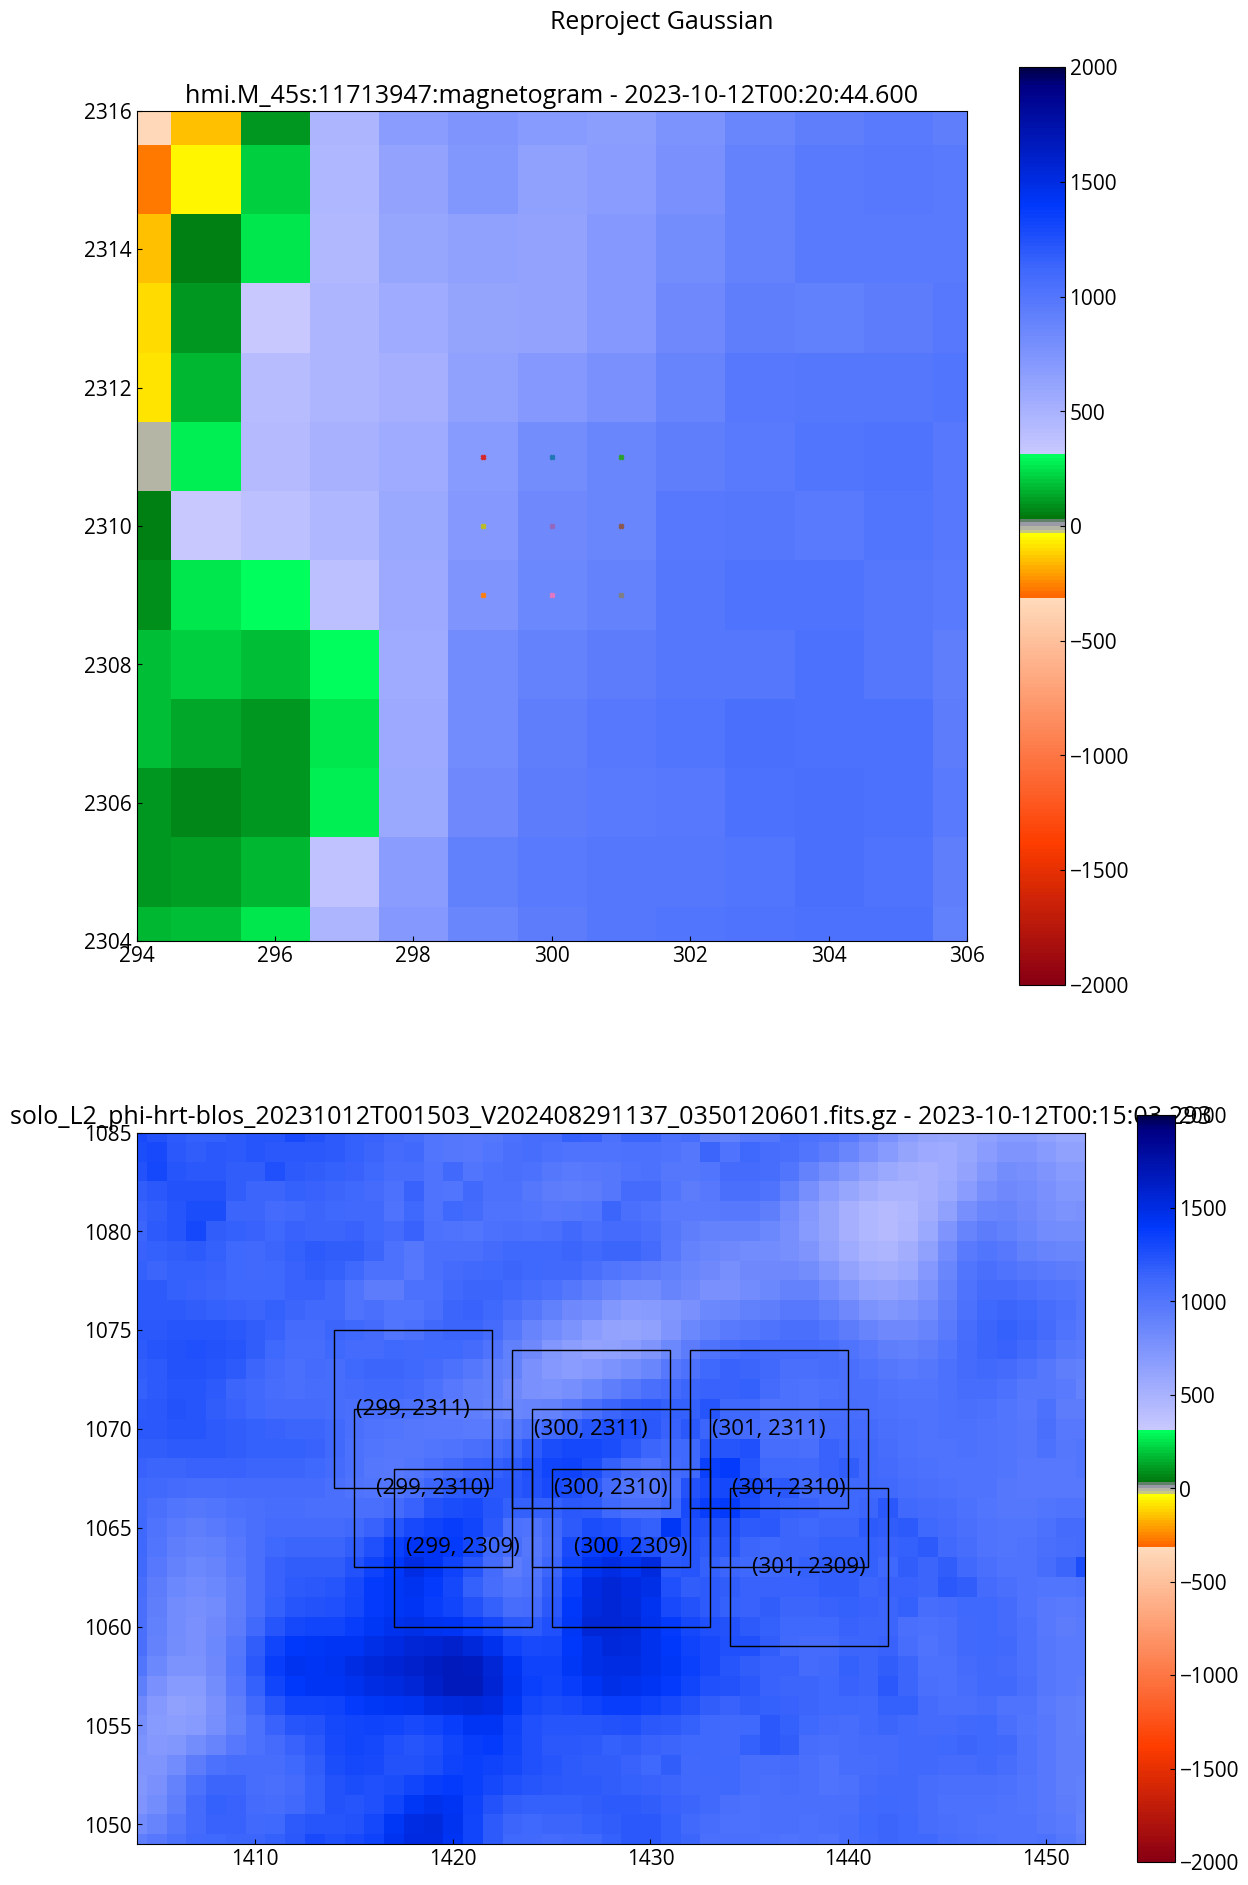

In [90]:
phi_dict=get_phi_pixels_and_neighbours_from_log_edges('./log_arlongterm_guassian_kernel.txt',300,2310,1)
plot_reproject_from_log(phi_dict,hmi_121023_b,hrt_121023_bm,title='Reproject Gaussian',fontsize=16)

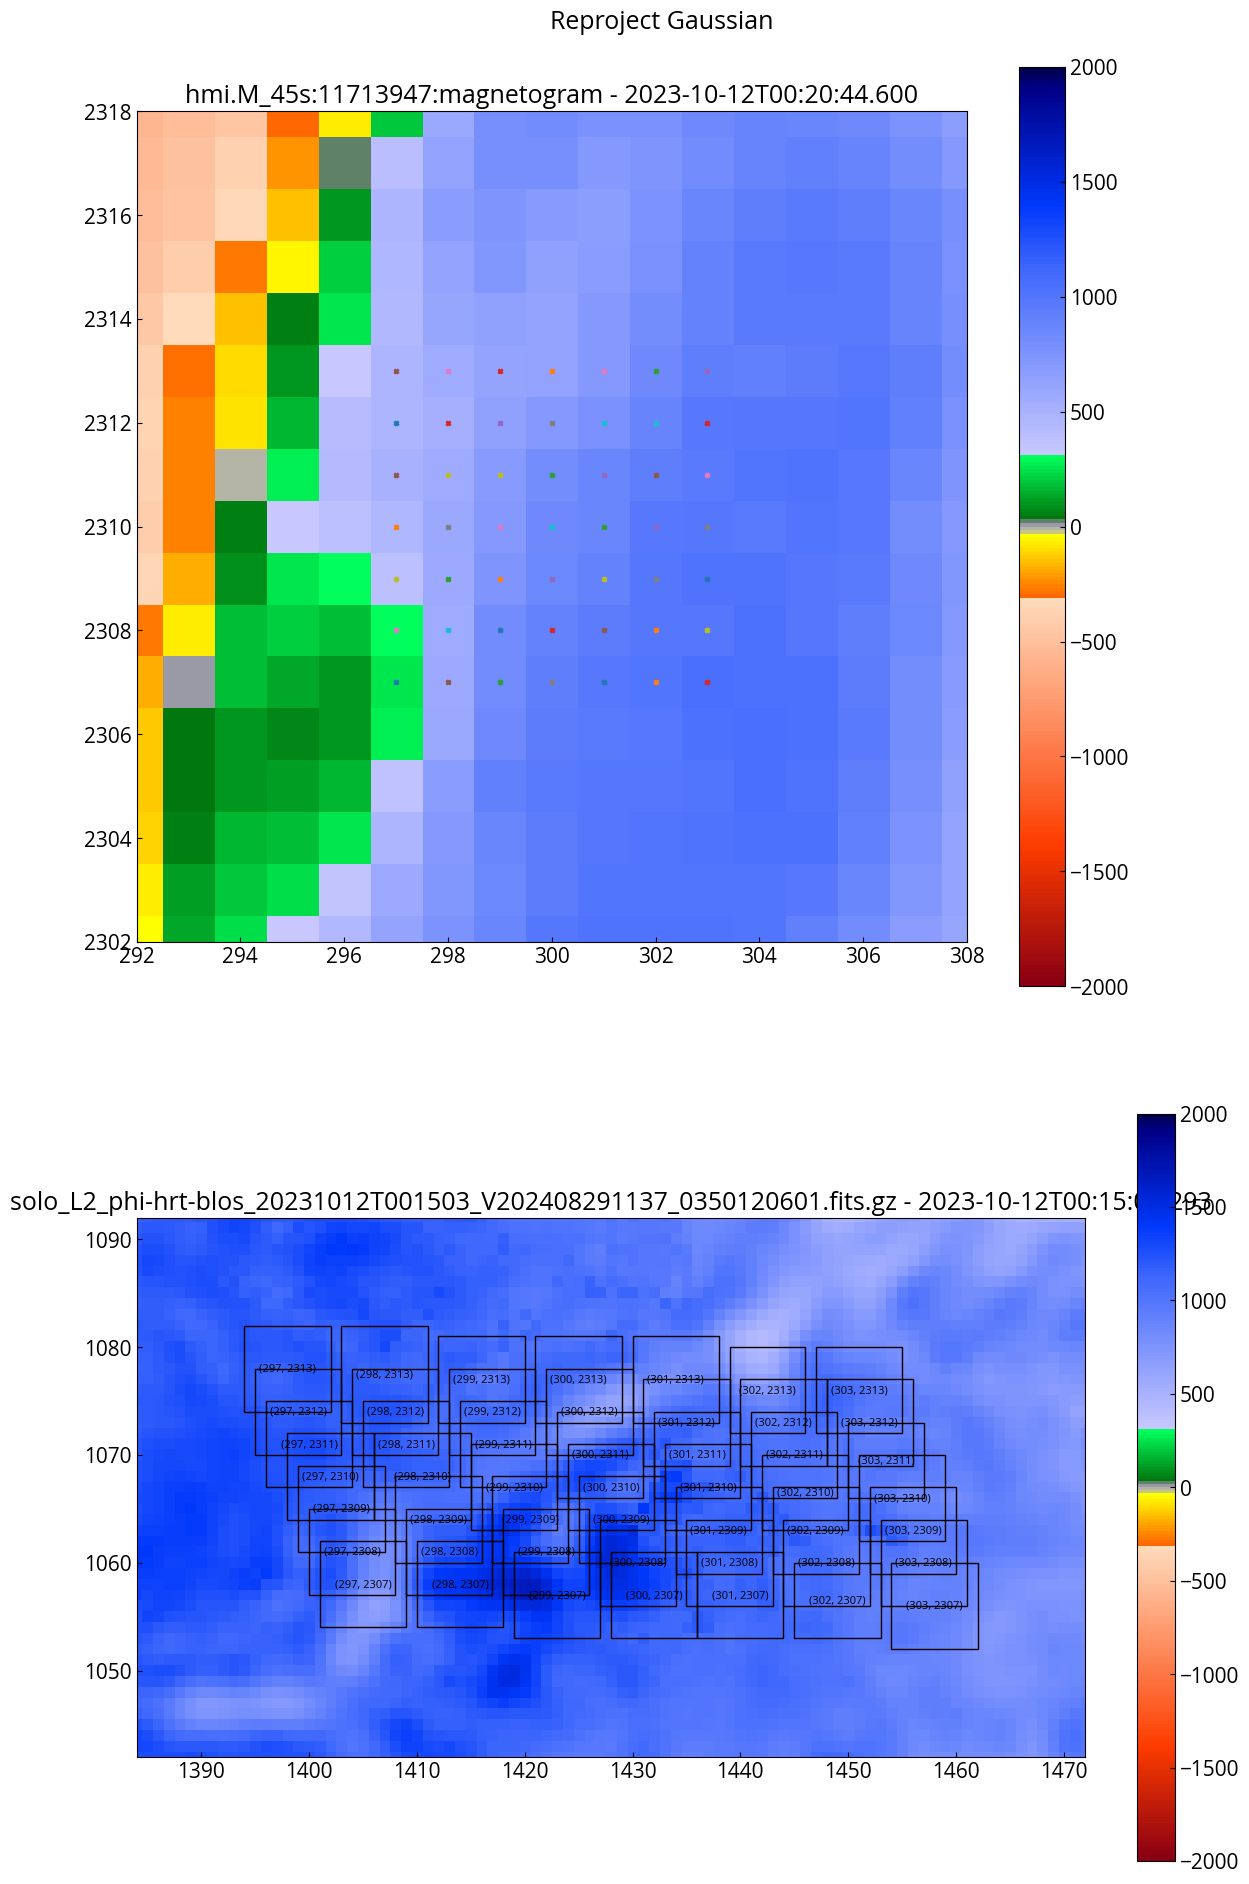

In [92]:
phi_dict=get_phi_pixels_and_neighbours_from_log_edges('./log_arlongterm_guassian_kernel.txt',300,2310,3)
plot_reproject_from_log(phi_dict,hmi_121023_b,hrt_121023_bm,title='Reproject Gaussian',fontsize=8)

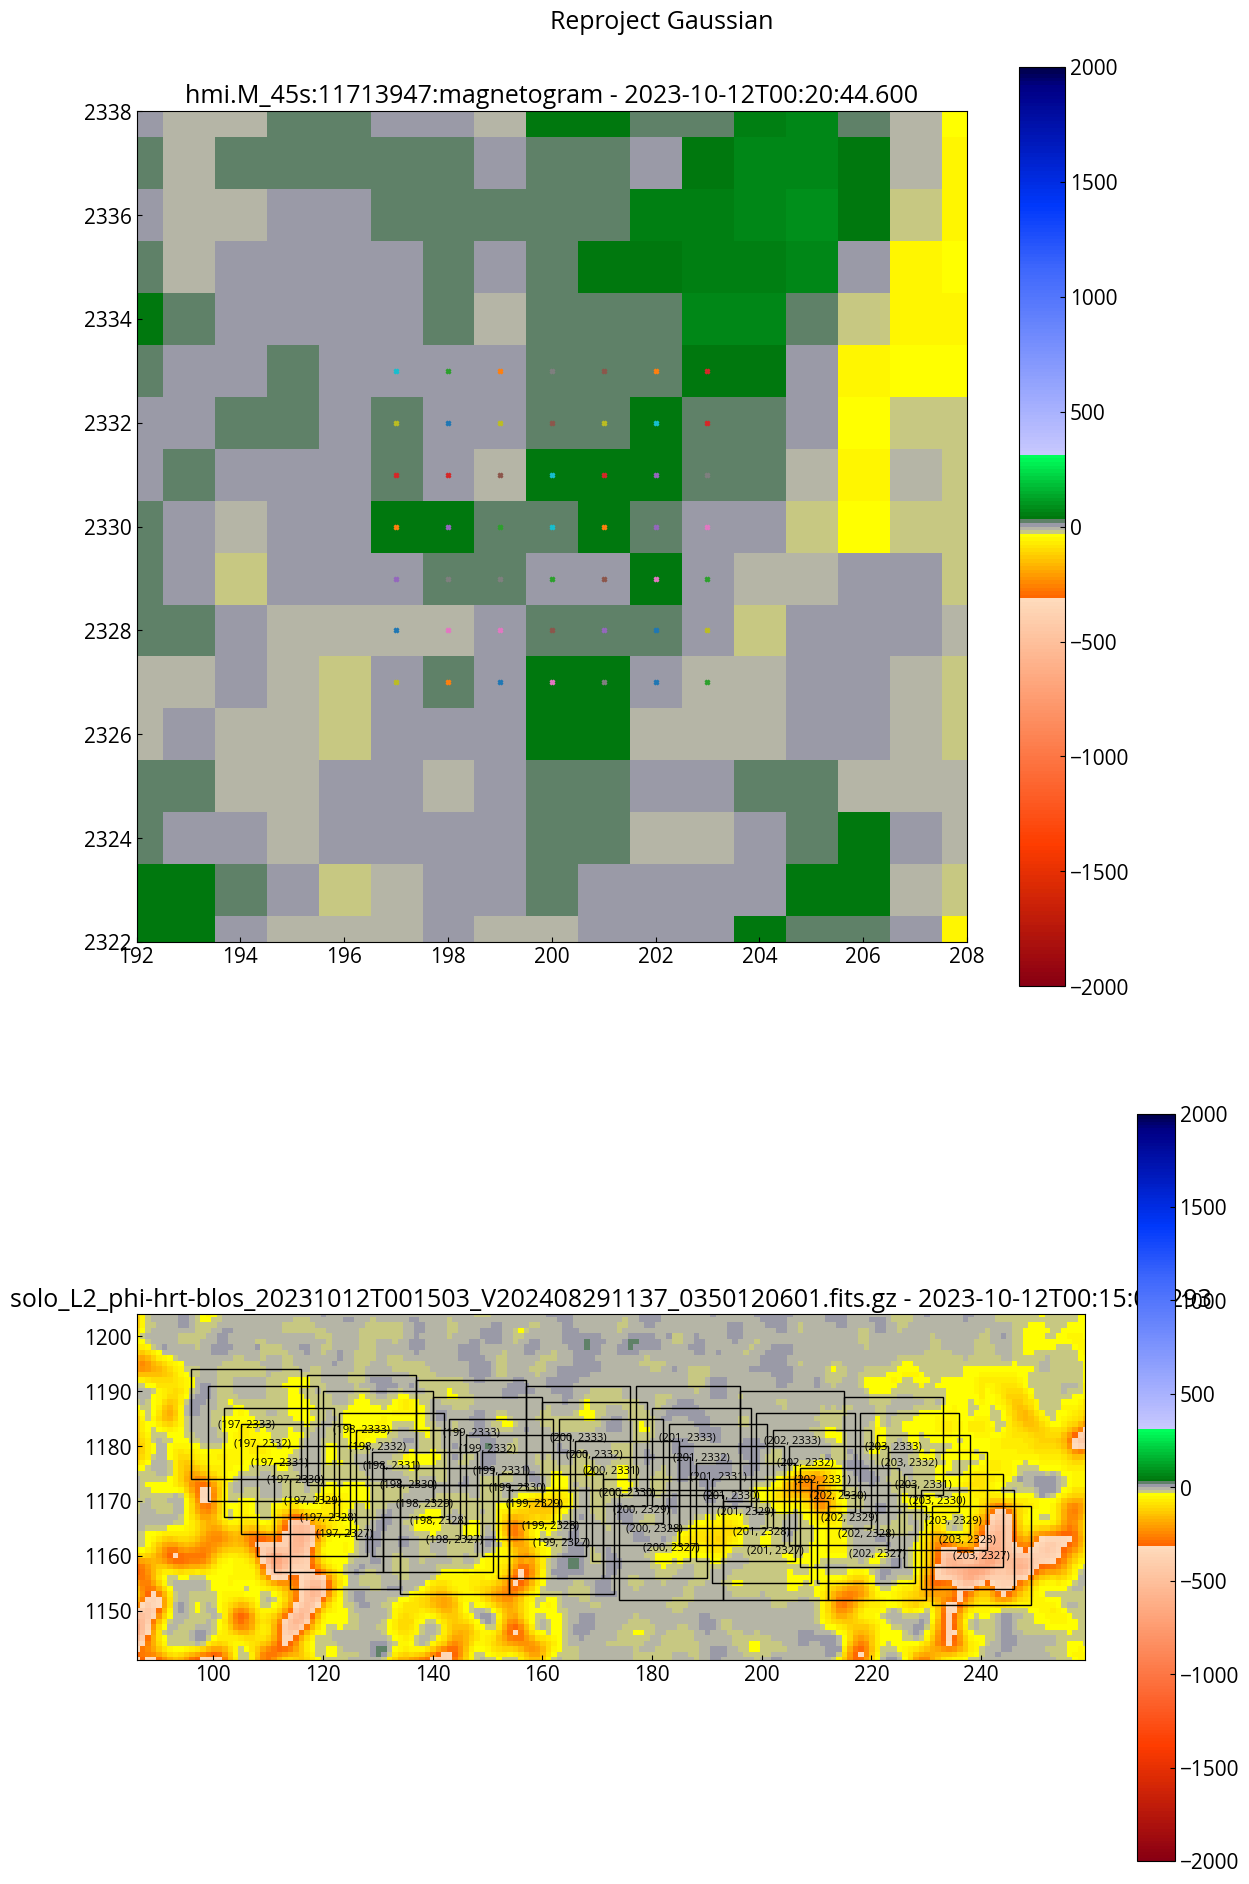

In [93]:
phi_dict=get_phi_pixels_and_neighbours_from_log_edges('./log_arlongterm_guassian_kernel.txt',200,2330,3)
plot_reproject_from_log(phi_dict,hmi_121023_b,hrt_121023_bm,title='Reproject Gaussian',fontsize=8)

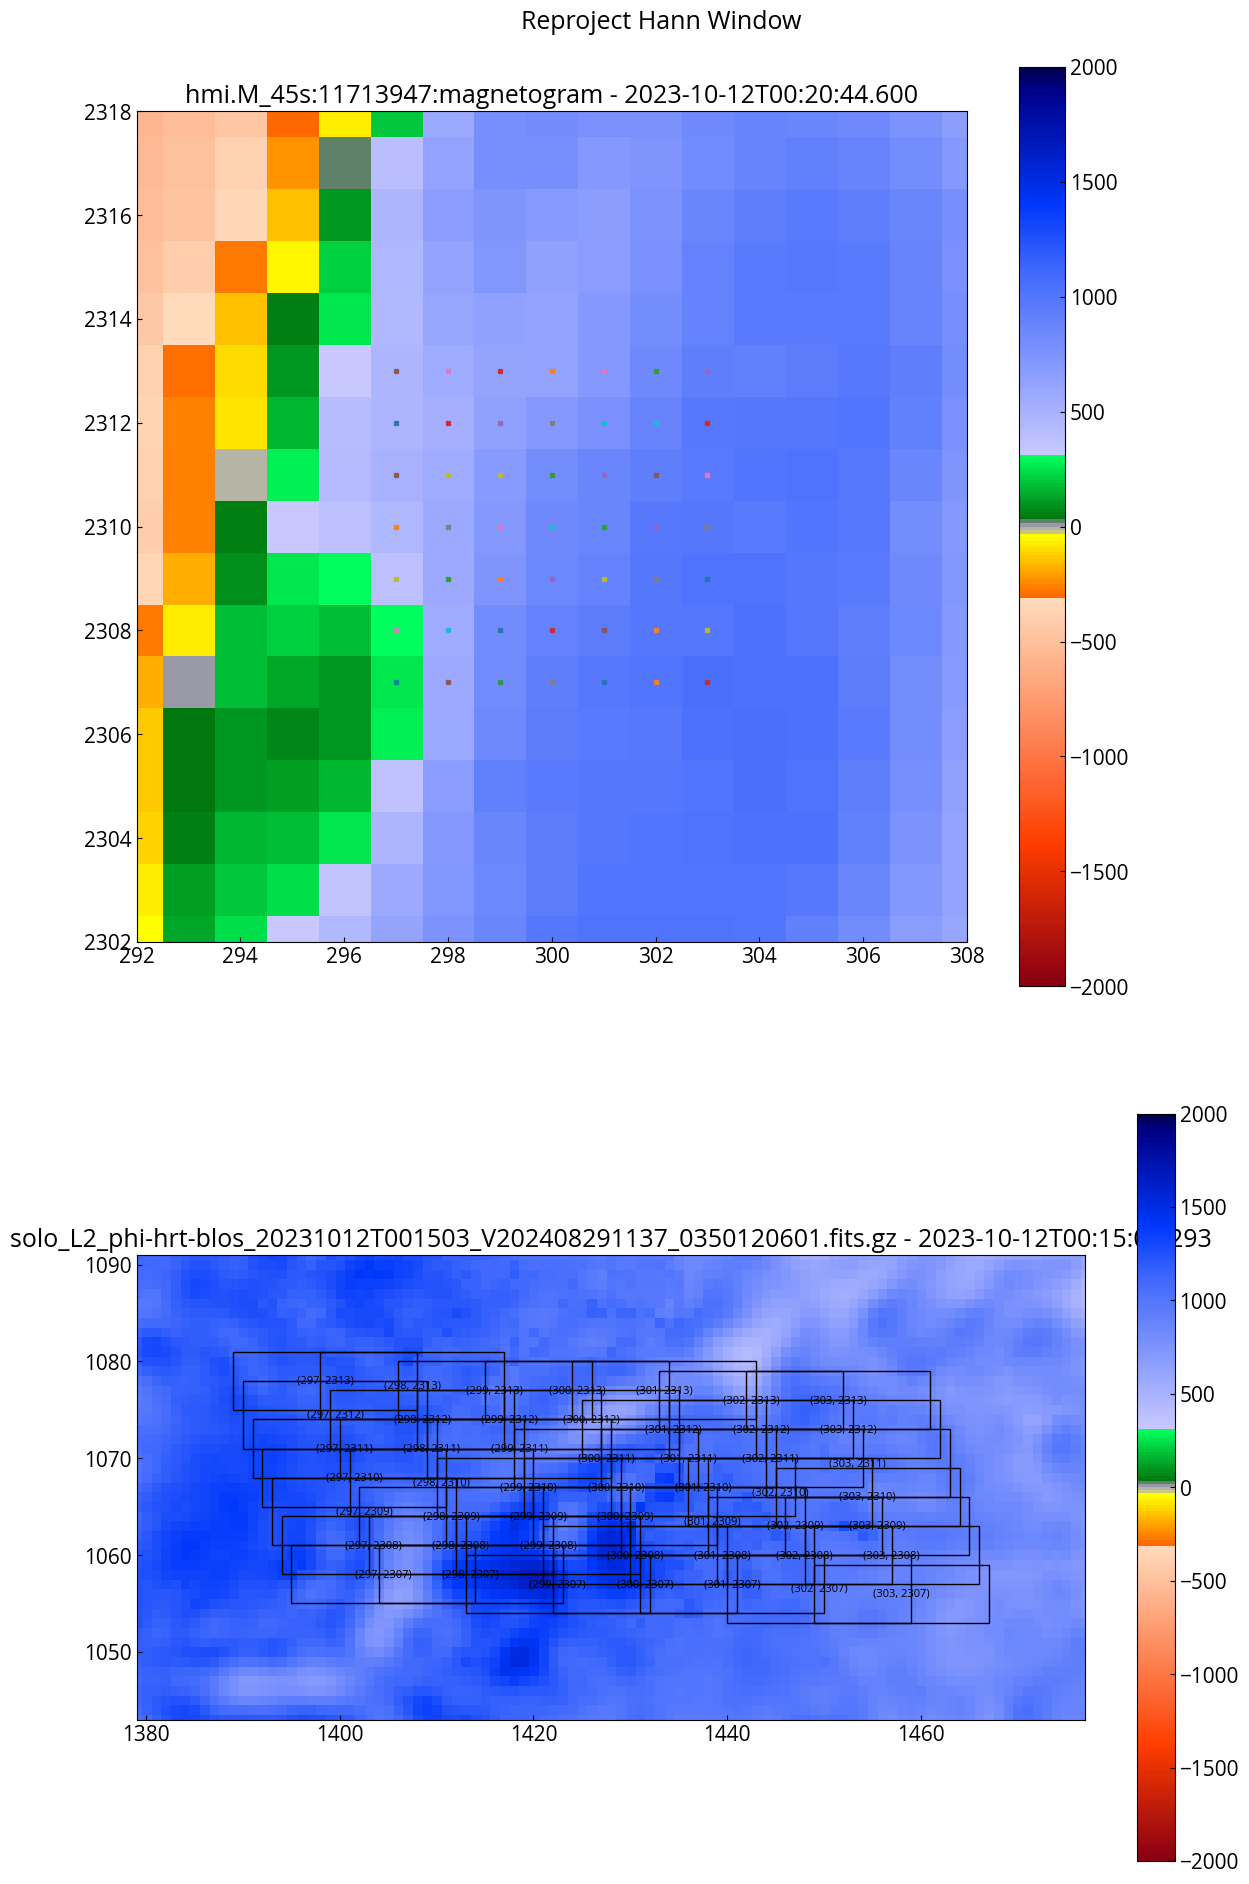

In [94]:
phi_dict=get_phi_pixels_and_neighbours_from_log_edges('./log_arlongterm.txt',300,2310,3)
plot_reproject_from_log(phi_dict,hmi_121023_b,hrt_121023_bm,title='Reproject Hann Window',fontsize=8)

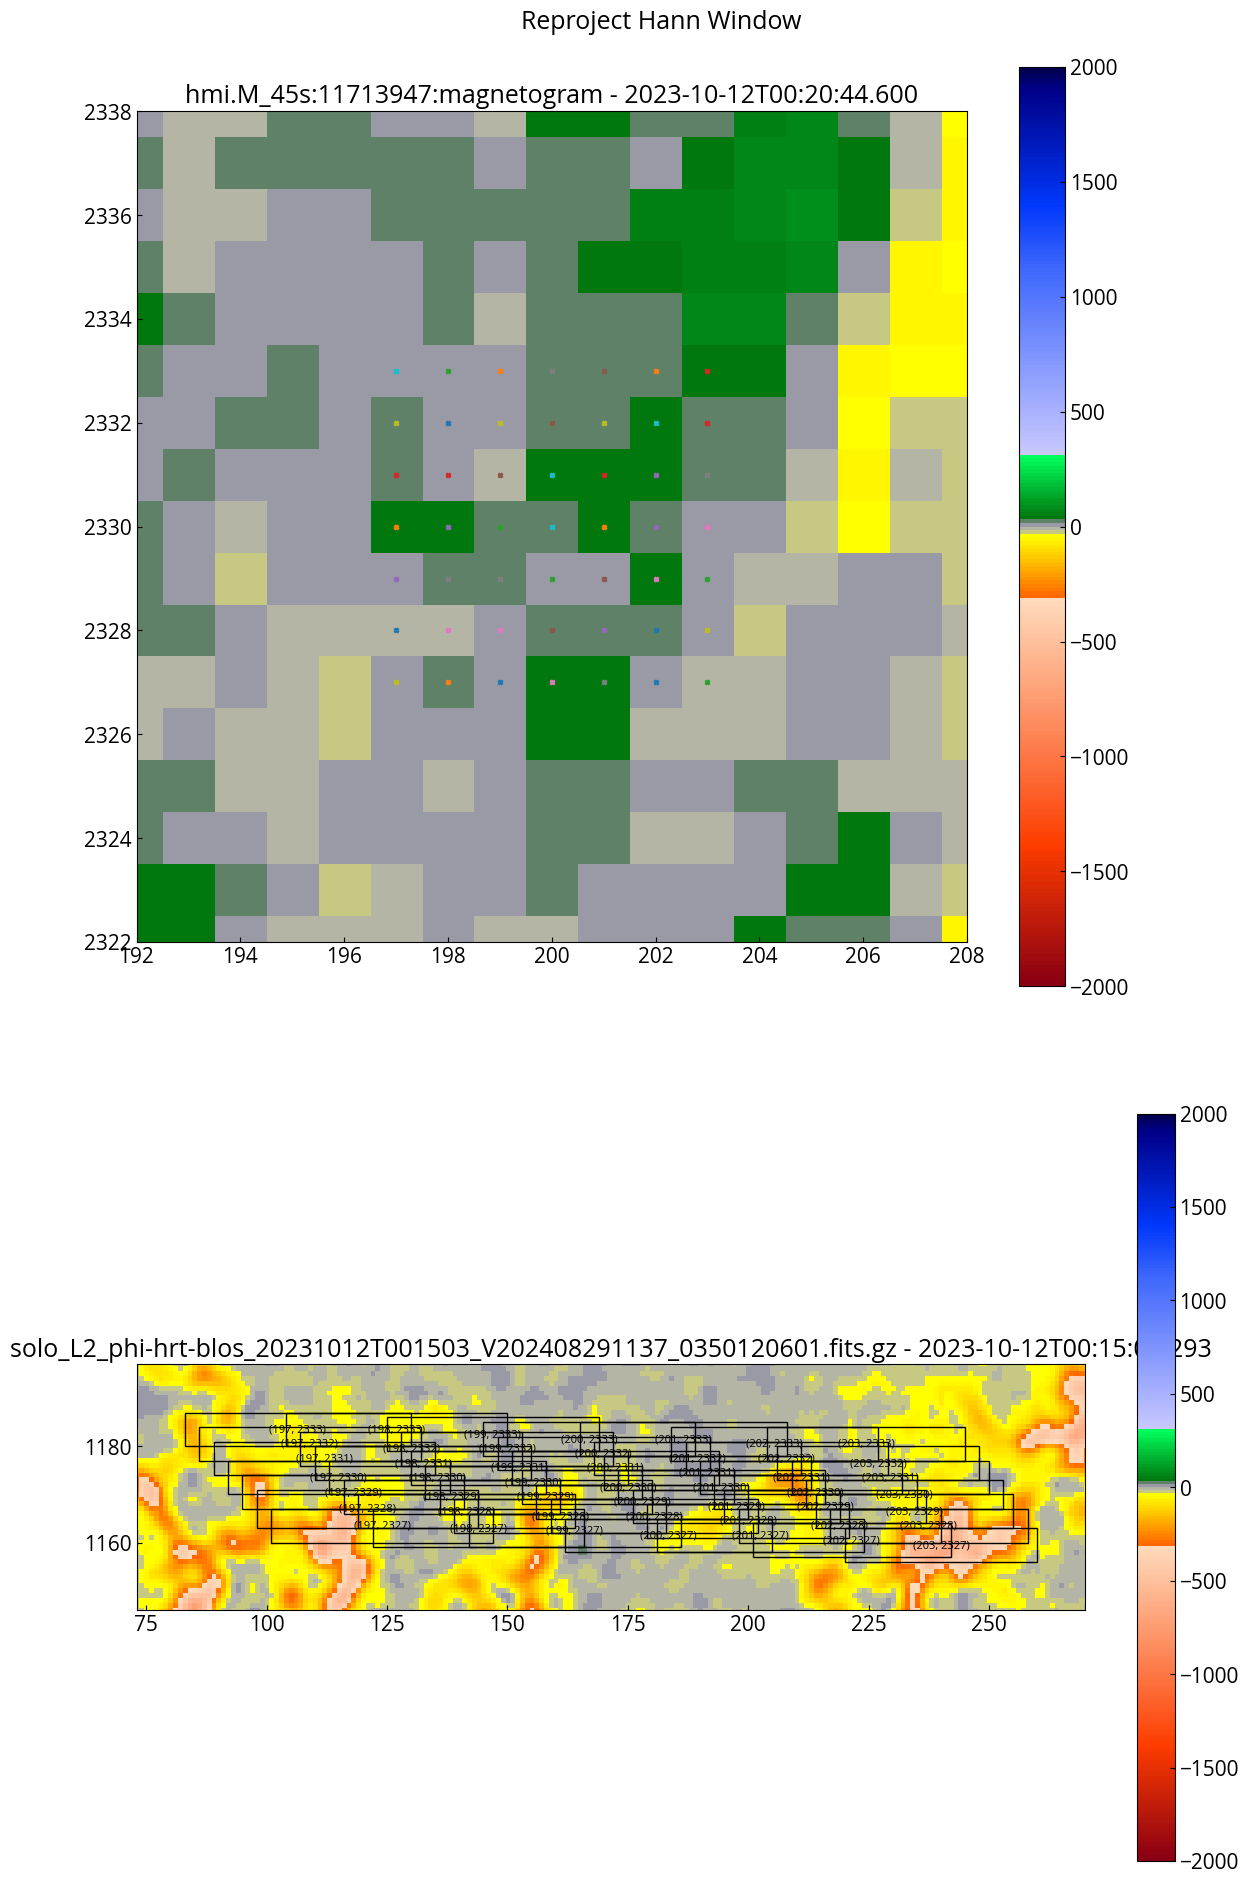

In [95]:
phi_dict=get_phi_pixels_and_neighbours_from_log_edges('./log_arlongterm.txt',200,2330,3)
plot_reproject_from_log(phi_dict,hmi_121023_b,hrt_121023_bm,title='Reproject Hann Window',fontsize=8)